In [1]:
! ls Data
print('')
! ls Data/output/

1519759656_39328483.csv
2017 PMP Data Final No Duplicates.xlsx
Federal_VDC_Relation_web_clean.xlsx
Federal_VDC_Relation_web.xlsx
nepalmonitor-reports.csv
nepal_population_household_ward-2011.csv
NM_2016_17export.csv
npl_polbanda_adm5_wad_25k_sdn_wgs84.csv
output

District_Province_Population  pop_incidents_VDC.csv
NM_2016_17clean.csv	      sources_vdc.csv


In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#set up a custom qualitative color palette
xkcd_colors = ['purple','green','blue','pink','brown','red','light blue',\
              'tan','light green','magenta','yellow','sky blue','teal','orange','light purple']
catpal = sns.xkcd_palette(xkcd_colors)



#Import Main Data Frames
cleanpath='Data/output/NM_2016_17clean.csv'#clean 2017 dataset
newpath = 'Data/nepalmonitor-reports.csv'#NM latest export - new site version for hold out set
df = pd.read_csv(cleanpath)
new_df = pd.read_csv(newpath)

print(df.shape[0],'x',df.shape[1])
print(new_df.shape[0], 'x',new_df.shape[1])

6630 x 68
5127 x 55


In [3]:
# convert 'INCIDENT DATE' column to date time objects (and limit to 2017) (and 18)
df['INCIDENT DATE'] = pd.to_datetime(df.loc[:,'INCIDENT DATE'])
df.index  = df['INCIDENT DATE']
df = df['2017']

new_df['Event Date'] = pd.to_datetime(new_df.loc[:,'Event Date'])
new_df['Publication Date'] = pd.to_datetime(new_df.loc[:,'Publication Date'])
new_df.index = new_df['Publication Date']
#new_df = new_df['2018'] < taken out to have part of the 2017 data

print(df.shape)
print(new_df.shape)

(3541, 68)
(5127, 55)


### Match (concat?_ 2017 and 2018 data

In [4]:
drop = ['CATEGORY','Municipality/VDC(New)','Ward(New)','Ward','Crosscutting issues','Weapon 2','Actor 2 entity name',
        'Number of Deaths','Development Region','Number of Injuries','Verification Feedback',
        'Event Date - Peace Monitoring','INCIDENT NUMBER','LATITUDE','LONGITUDE',
        'VERIFIED','LOCATION','Zone','District(New)','Election-related  specific cause primary',
        'Election-related specific cause secondary','INCIDENT DATE','INCIDENT TITLE']

new_drop = ['#','Title','Nepali Title', 'Ward','Publication Date','Event Date',
            'Province','Nepali Description','Tags','Location','Latitude','Longitude']

train_df = df.dropna(axis=1, how='all')#.sort_index(axis=1)
test_df = new_df.dropna(axis=1, how='all')#.sort_index(axis=1)


train_df.drop(drop, axis=1, inplace=True)
test_df.drop(new_drop, axis=1, inplace=True)

train_df.rename(columns={'Actor 1 Entity Name': 'Actor 1 - Entity',
                         #': 'Actor 2 - Entity',
                         'Actor 1 - Perpetrator Type':'Actor 1 - Affiliation',
                         'Perpetrator 2 - if two-sided violence':'Actor 2 - Affiliation',
                         'Actor 1 - Youth -25 years or below- involvement': 'Actor 1 - Youth/non-youth',
                         'Actor 2 - Youth -25 years or below- involvement': 'Actor 2 - Youth/non-youth',
                         'Actor 2 Numbers':'Actor 2 - Number of people',
                         
                        }, inplace=True)

test_df = test_df.reindex(columns=['Description', 'HLCIT Code', 'Location Accuracy', 'District', 'Municipality/VDC',
 'Source', 'Source Type', 'Duration - only applicable to non-violent forms', 
 'Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 
 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 
 'Cause - Secondary','Actor 1 - Number of people','Actor 1 - Affiliation', 'Actor 1 - Entity', 
 'Actor 1 - Youth/non-youth', 'Actor 2 - Number of people', 'Actor 2 - Target', 'Actor 2 - Affiliation',
 'Actor 2 - Youth/non-youth', 'Total killed', 'Female killed', 'Youth killed', 'Total injured', 'Female injured',
 'Youth injured', 'Total raped', 'Female raped', 'Youth raped', 'Total abducted', 'Female abducted', 
 'Youth abducted', 'Total damaged buildings', 'Severely damaged buildings', 'Total damaged vehicles', 
 'Severely damaged vehicles'])

#train_df.sort_index(axis=1, inplace=True)
#test_df.sort_index(axis=1, inplace=True)

print(train_df.shape,test_df.shape)

for col in zip(train_df.columns,test_df.columns):
    print(col)
#print(test_df.columns)

(3541, 40) (5127, 40)
('DESCRIPTION', 'Description')
('HLCIT CODE', 'HLCIT Code')
('LOCATION ACCURACY', 'Location Accuracy')
('District', 'District')
('Municipality/VDC', 'Municipality/VDC')
('SOURCE', 'Source')
('SOURCE TYPE', 'Source Type')
('Duration - only applicable to non-violent forms', 'Duration - only applicable to non-violent forms')
('Violent vs non-violent', 'Violent / Nonviolent')
('One-sided vs two-sided', 'Onesided / Twosided')
('Collective vs interpersonal', 'Collective / Interpersonal')
('Event form - primary', 'Event Form - Primary')
('Event form - secondary', 'Event Form - Secondary')
('Weapon', 'Weapons')
('Cause - primary', 'Cause - Primary')
('Cause - secondary', 'Cause - Secondary')
('Actor 1 - Number of People', 'Actor 1 - Number of people')
('Actor 1 - Affiliation', 'Actor 1 - Affiliation')
('Actor 1 - Entity', 'Actor 1 - Entity')
('Actor 1 - Youth/non-youth', 'Actor 1 - Youth/non-youth')
('Actor 2 - Number of people', 'Actor 2 - Number of people')
('Target - i

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nhorning/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [5]:
train_df.columns = test_df.columns
full_df = test_df#train_df.append(test_df) < it looks like the variables are coded differently let's just use 1 dataset for now
full_df['Total killed'] = (full_df.loc[:,'Total killed'] == '1').astype(float)
full_df.head()

,Description,HLCIT Code,Location Accuracy,District,Municipality/VDC,Source,Source Type,Duration - only applicable to non-violent forms,Violent / Nonviolent,Onesided / Twosided,...,Total raped,Female raped,Youth raped,Total abducted,Female abducted,Youth abducted,Total damaged buildings,Severely damaged buildings,Total damaged vehicles,Severely damaged vehicles
Publication Date,,,,,,,,,,,,,,,,,,,,,
2018-11-15,People in Pushpalal Chok of Nepalgunj were ter...,NP0557201,municipality,Banke,Nepalgunj,http://kathmandupost.ekantipur.com/news/2018-1...,National/Online Media,NaN,violent,onesided,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-14,The police have rescued 35 child workers from...,NP0327101,municipality,Kathmandu,Kathmandu,https://myrepublica.nagariknetwork.com/news/35...,National/Online Media,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-15,Police have launched an investigation after a ...,NP0217310,municipality,Dhanusha,Bideha,http://annapurnapost.com/news/112833\nhttps://...,National/Online Media,NaN,violent,onesided,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-13,A man attacked three persons with a Khukuri—a ...,524 3 09 46 5 002 3,ward,Taplejung,Phungling,http://kathmandupost.ekantipur.com/news/2018-1...,National/Online Media,NaN,violent,onesided,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-13,Police have arrested 54 years old ward secreta...,524 3 09 46 5 002 4,ward,Rupandehi,Tillotama,http://inseconline.org/en/news/witch-craft-all...,National/Online Media\nINSEC,NaN,violent,onesided,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Start with some time series analysis - predict levels of violence based on previous weeks.

In [6]:
#One-hot encode categorical columns
dummies = ['Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 
 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 
 'Cause - Secondary','Actor 1 - Number of people','Actor 1 - Affiliation', 'Actor 1 - Entity', 
 'Actor 1 - Youth/non-youth', 'Actor 2 - Number of people', 'Actor 2 - Target', 'Actor 2 - Affiliation',
 'Actor 2 - Youth/non-youth']
incidents_date = pd.get_dummies(full_df, columns=dummies)

in_week = incidents_date.resample('W').sum()
in_day = incidents_date.resample('D').sum()
in_week.head()
print(in_week.shape)
print(in_day.shape)

(78, 450)
(542, 450)


In [7]:
in_day.columns

Index(['Total killed', 'Female killed', 'Youth killed', 'Total injured',
       'Female injured', 'Youth injured', 'Total raped', 'Female raped',
       'Youth raped', 'Total abducted',
       ...
       'Actor 2 - Affiliation_Security forces - Police',
       'Actor 2 - Affiliation_Security forces - Police\nSecurity forces - Police',
       'Actor 2 - Affiliation_Security forces - Security forces (unspecified)',
       'Actor 2 - Affiliation_Security forces - Security forces (unspecified)\nSecurity forces - Security forces (unspecified)',
       'Actor 2 - Affiliation_Students', 'Actor 2 - Affiliation_Unclear',
       'Actor 2 - Youth/non-youth_na', 'Actor 2 - Youth/non-youth_noyouth',
       'Actor 2 - Youth/non-youth_unknown', 'Actor 2 - Youth/non-youth_youth'],
      dtype='object', length=450)

In [8]:
#function for converting pandas time series df to training set for supervised learning
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
        Pandas DataFrame of series framed for supervised learning.
        https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
#Create a time shifted dataframe of all variables.
def make_timeshift(df, lookback):
    time_shift = series_to_supervised(df, lookback, dropnan=False).fillna(0)
    return time_shift

time_shift_week = make_timeshift(in_week, 5)
time_shift_day = make_timeshift(in_day, 5)
print(time_shift_day.shape)
time_shift_day.head()

(542, 2700)


,Total killed(t-5),Female killed(t-5),Youth killed(t-5),Total injured(t-5),Female injured(t-5),Youth injured(t-5),Total raped(t-5),Female raped(t-5),Youth raped(t-5),Total abducted(t-5),...,Actor 2 - Affiliation_Security forces - Police(t),Actor 2 - Affiliation_Security forces - Police Security forces - Police(t),Actor 2 - Affiliation_Security forces - Security forces (unspecified)(t),Actor 2 - Affiliation_Security forces - Security forces (unspecified) Security forces - Security forces (unspecified)(t),Actor 2 - Affiliation_Students(t),Actor 2 - Affiliation_Unclear(t),Actor 2 - Youth/non-youth_na(t),Actor 2 - Youth/non-youth_noyouth(t),Actor 2 - Youth/non-youth_unknown(t),Actor 2 - Youth/non-youth_youth(t)
Publication Date,,,,,,,,,,,,,,,,,,,,,
2017-05-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train your predictive model on the above data frame.
For any given variable t-n represents one step back. 
try to find a way to predict everything with everything? find out which are the most acurate?
 - let's start with one. 
  - note... at some point try to preserve labels, so you know what is actually contributing. 

must create train test sets of the array above
test reserve will be this years data


In [73]:
#Create X y - also do the holdhout split (perhapse change this later so it splits based on length )
def create_X_y(df, holdpc=.2):
    holdsize = int(holdpc * len(df.index))
    y = df.loc[:,'Total killed(t)':].iloc[:-holdsize,:]
    X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-1)'].iloc[:-holdsize,:]
    
    holdout_y = df.loc[:,'Total killed(t)':].iloc[-holdsize:,:]
    holdout_X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-1)'].iloc[-holdsize:,:]

    return X, y, holdout_X, holdout_y

X_day, y_day, holdout_X_day, holdout_y_day = create_X_y(time_shift_day)

X_week, y_week, holdout_X_week, holdout_y_week = create_X_y(time_shift_week)

for x in [X_day, y_day, holdout_X_day, holdout_y_day, X_week, y_week, holdout_X_week, holdout_y_week]:
    print(x.shape)


y_day.head()

(434, 2250)
(434, 450)
(108, 2250)
(108, 450)
(63, 2250)
(63, 450)
(15, 2250)
(15, 450)


,Total killed(t),Female killed(t),Youth killed(t),Total injured(t),Female injured(t),Youth injured(t),Total raped(t),Female raped(t),Youth raped(t),Total abducted(t),...,Actor 2 - Affiliation_Security forces - Police(t),Actor 2 - Affiliation_Security forces - Police Security forces - Police(t),Actor 2 - Affiliation_Security forces - Security forces (unspecified)(t),Actor 2 - Affiliation_Security forces - Security forces (unspecified) Security forces - Security forces (unspecified)(t),Actor 2 - Affiliation_Students(t),Actor 2 - Affiliation_Unclear(t),Actor 2 - Youth/non-youth_na(t),Actor 2 - Youth/non-youth_noyouth(t),Actor 2 - Youth/non-youth_unknown(t),Actor 2 - Youth/non-youth_youth(t)
Publication Date,,,,,,,,,,,,,,,,,,,,,
2017-05-24,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


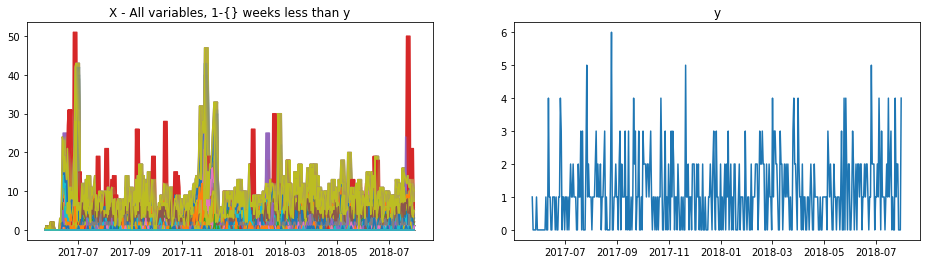

train score: 0.63696369637
test score: 0.297709923664
R2 score: -0.327291318089
confusion matrix
 [[ 9 28  8  0  0  0]
 [ 8 28  7  0  0  0]
 [ 4 23  2  0  0  0]
 [ 2  4  2  0  0  0]
 [ 1  4  0  0  0  0]
 [ 0  1  0  0  0  0]]
Initial test score not promissing. No crossvalidation


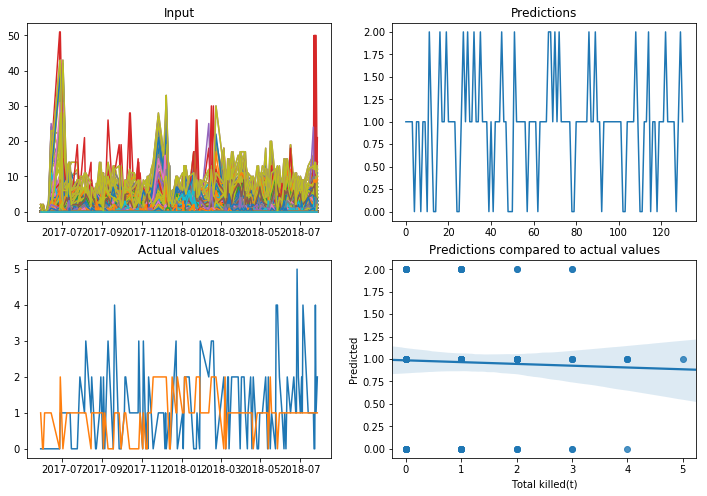

In [74]:
#Train and test a model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

#create imputer for nan values 
imp = Imputer(missing_values='NaN', strategy = 'mean')

def plot_model(X_test, y_test, y_pred):
    sync = pd.DataFrame({'Actual Values':y_test, 'Predictions':y_pred}, index=y_test.index)
        
    f, (ax0, ax1) = plt.subplots(2,2, figsize=(12,8))
    ax0[0].plot(X_test.sort_index())
    ax0[0].set_title('Input')
    ax0[1].plot(y_pred)
    ax0[1].set_title('Predictions')
    ax1[0].plot(sync.sort_index())
    ax1[0].set_title('Actual values')
    #sns.grid.ax1[0].legend()
    sns.regplot(y_test, y_pred)
    ax1[1].set_title('Predictions compared to actual values')
    ax1[1].set_ylabel('Predicted')
    plt.show()

    
def test_model(X_train, X_test, y_train, model):
    #fit the model to the training set
    model.fit(X_train, y_train)

    #predict outcomes beased on training set
    y_pred = model.predict(X_test)
    
    return y_pred, model

def score_model(X_train, X_test, y_train, y_test, y_pred, model):
    
    #score model
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    r_2 = r2_score(y_test.astype(float), y_pred.astype(float))
    cm = confusion_matrix(y_test, y_pred)
    
    return train_score, test_score, cm, r_2

    
#create fuction to train model and find a variable than can be predicted from the previous week's data
def try_model(X, y, model, verbose=0):


    #Split X and Y into training and testing sets... #we'll use this years data as the hold out set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)
    
    #use function above to train model and create predictions
    y_pred, model = test_model(X_train, X_test, y_train, model)
    
    #use function above to score the model based on predictions
    train_score, test_score, cm, r_2 = score_model(X_train, X_test, y_train, y_test, y_pred, model)
    
    #extract log probabilites(may have to change this to coef and interpret everything as a linear model)
    eye = np.eye(X_test.shape[1])
    log_proba = pd.DataFrame(model.predict_log_proba(eye), index = X.columns)
    
    #check if the true negatives and true positives are at least as big as the false negatives and false positives   
    cv_done = False
    cv_score = np.array([0,0,0])
    if cm.shape == (2,2):
        if cm[0][0] > cm[1][0] and cm[1][1] > cm[0][1]:
            cv_score = cross_val_score(model, X, y, cv=3,)# scoring='r2')
            cv_done = True
    else:
        #r_2 = r2_score(y_test.values, y_pred)
        if r_2 > 0:
            cv_score = cross_val_score(model, X.astype(float), y.astype(float), cv=3, scoring='r2')
            cv_done = True
    
    if verbose > 0:
        #print scores
        print('train score:', train_score )
        print('test score:', test_score)
        print('R2 score:', r_2)
        print('confusion matrix\n',cm)#n,p\nn', cm[0],'\np',cm[1])
        if cv_done == True:
            print('crossvalidation mean:',cv_score.mean(), cv_score)
        else:
            print('Initial test score not promissing. No crossvalidation')
        #print('Top Feature Probabilities:', log_proba.sort_values(1, axis=1, ascending=False))
        #print('Bottom Feature Probabilities:', bottom_prob)
    
    if verbose > 1:
        #Plot what these look like
        plot_model(X_test, y_test, y_pred)
       
    return cv_score, test_score, cm, r_2, log_proba

#define y
y = y_day.loc[:,'Total killed(t)']# > in_week.loc[:,'Total killed'].quantile(.5)      

#Plot what X and y look like
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(X_day)
ax1.set_title('X - All variables, 1-{} weeks less than y')#.format(int(lookback)))
ax2.plot(y)
ax2.set_title('y')
plt.show()

#give the function to try the model a dry run
dry_run = try_model(X_day, y, MultinomialNB(), verbose = 2)


In [65]:
#find which variables have the best crossvalidation scores
def find_var (X, df, model, n_true, verbose=False):
    scores = pd.DataFrame(index=df.columns, columns=['cv_mean','test_score','confusion_matrix','r_2','pc_true'])
    for var in df.columns:
        y = df[var] > df[var].quantile(.5)
        #X = time_shift.loc[:,'var1(t-1)':'var340(t-1)']
        n_class = y.nunique()
        n_bins = 10
        #n_true = 10
        pc_true = sum(y >= 1)/len(y)*100
        
        if verbose == True:
            print('\n')
            print(var)
        if verbose == False:
                print('.', end='')
        if pc_true > n_true: #make it a percentage
      
            cv_score, test_score, cm, r_2, log_proba = try_model(X, y, model, verbose = verbose)
            
            
        
                  
            scores['cv_mean'][var] = cv_score.mean()
            scores['test_score'][var] = test_score
            scores['confusion_matrix'][var] = cm
            scores['r_2'][var] = r_2
            scores['pc_true'][var] = pc_true
            #print(scores[var])
    
    #print('bing!')
    
    return scores
#scores = find_var(X_day, y_day, MultinomialNB(), n_true=20, verbose=0)

#top10 = scores.sort_values('cv_mean', ascending=False)[:10]
#top10

In [76]:
def interpet_prob(log_proba):
    pd.set_option('display.max_colwidth', 200)
    print(np.exp(log_proba).sort_values(0)[:2])
    print(np.exp(log_proba).sort_values(1)[:2])
    sns.heatmap(np.exp(log_proba).sort_values(1))
    plt.show()

def investigate(cats, X_train, y_train, holdout_X, holdout_y, model, verbose=1):
    #function to look futher into better performing results
    holdout_scores = pd.DataFrame(index=cats, columns=['test_score','confusion_matrix','r_2'])
    for cat in cats:
        y = y_train[cat]# > y_train[cat].quantile(.5)
        if verbose > 0:
            print('\n',cat)
            cv_score, test_score, cm, r_2, log_proba = try_model(X_train, y, model, verbose = 2)
            interpet_prob(log_proba)
        
        h_y = holdout_y[cat]# > holdout_y[cat].quantile(.5)
        y_pred, model = test_model(X_train, holdout_X, y, model)
        train_score, test_score, cm, r_2 = score_model(X_train, holdout_X, y, h_y, y_pred, model)
        holdout_scores['test_score'][cat] = test_score
        holdout_scores['confusion_matrix'][cat] = cm
        holdout_scores['r_2'][cat] = r_2
    return holdout_scores

In [77]:
#create function to optimize lookback!

def opt_lookback(df, model):
    '''function to optimize number of units to look back through time'''
    print('Optimizing...')
    scorelist = []
    categories = df.columns.tolist()
    scoredf = pd.DataFrame(index=categories)
    #loop through possible ranges to look back at to find the the optimum value
    for lookback in range(1, 90):
        #create a timeshifted dataframe within that range
        time_shift = make_timeshift(df, lookback)
        
        #split timeshift into training and hold out data sets
        X, y, holdout_X, holdout_y = create_X_y(time_shift)
        
        #find the scores for all the variables (those which have more positives than negatives)
        scores = find_var(X, y, model, n_true=20, verbose=0)
        
        #find the sum of the crossvalidation scores
        cv_score=scores['cv_mean'].sum()
        
        #find which variables recieved a score
        top_scores = scores.loc[scores['cv_mean'] > 0].index
        
        #use investigate function to see how those variables did against the holdout set
        holdout_scores = investigate(top_scores, X, y, holdout_X, holdout_y, model, verbose=0)             
        
        #find the sum of the hold out test scores scores
        holdout_mean = holdout_scores['test_score'].sum()
        
        #print the lookback interval, and mean scores
        print('\nt-{0} mean_cv sum: {1:.2f}, holdout_mean sum: {2:.2f} '.format(lookback,cv_score,holdout_mean))
        
        #append the crossvalidation score to the list
        scorelist.append(cv_score)
        
        #join the scores to the data frame of scores
        scoredf = scoredf.join(scores, how='right', rsuffix=('(t-'+str(lookback)+')'))
        scoredf = scoredf.join(holdout_scores, how='right', rsuffix='_holdout(t-'+str(lookback)+')')
        
        #if the 
        if np.median(scorelist[-10:]) < np.median(scorelist):
            
            return scoredf

scoredf_day = opt_lookback(in_day, MultinomialNB())
scoredf_week = opt_lookback(in_week, MultinomialNB())
print('bing!')

scoredf_week.head()
#plt.plot(scoredf_day)#, label = 'by day')
#plt.plot(scoredf_week, label = 'by week')
#plt.title('Mean crossvalidation scores v. lookback times')
#plt.legend()
#plt.show()

Optimizing...
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................
t-1 mean_cv sum: 17.00, holdout_mean sum: 11.77 
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................
t-2 mean_cv sum: 14.39, holdout_mea

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................
t-6 mean_cv sum: 28.74, holdout_mean sum: 20.13 
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................
t-7 mean_cv sum: 31.22, holdout_mean sum: 23.60 


,cv_mean,test_score,confusion_matrix,r_2,pc_true,test_score_holdout(t-1),confusion_matrix_holdout(t-1),r_2_holdout(t-1),cv_mean(t-2),test_score(t-2),...,confusion_matrix_holdout(t-10),r_2_holdout(t-10),cv_mean(t-11),test_score(t-11),confusion_matrix(t-11),r_2(t-11),pc_true(t-11),test_score_holdout(t-11),confusion_matrix_holdout(t-11),r_2_holdout(t-11)
Female killed(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0,...",-0.715686,0.282468,0.684211,"[[6, 5], [1, 7]]",-0.295455,46.0317,0,"[[0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0,...",-0.715686
Female injured(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[0, 0, 2, 0, 0], [0, 0, 5, 0, 0], [0, 0, 2, 0, 0], [1, 0, 1, 0, 0], [0, 0, 4, 0, 0]]",-0.346939,0.651804,0.684211,"[[8, 4], [2, 5]]",-0.357143,44.4444,0.133333,"[[0, 0, 2, 0, 0], [0, 0, 5, 0, 0], [0, 0, 2, 0, 0], [0, 0, 2, 0, 0], [1, 0, 3, 0, 0]]",-0.438776
Total raped(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, ...",-0.379896,0.486724,0.736842,"[[9, 2], [3, 5]]",-0.0795455,46.0317,0.0666667,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",-0.522193
Youth raped(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1...",-0.243427,0.504185,0.789474,"[[4, 3], [1, 11]]",0.0952381,44.4444,0.0666667,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1...",-0.257957
Violent / Nonviolent_violent(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, ...",-1.35989,0.521717,0.842105,"[[7, 3], [0, 9]]",0.366667,49.2063,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, ...",-1.17332


In [63]:
scoredf_day.head()

,cv_mean,test_score,confusion_matrix,r_2,pc_true,test_score_holdout(t-1),confusion_matrix_holdout(t-1),r_2_holdout(t-1),cv_mean(t-2),test_score(t-2),...,confusion_matrix_holdout(t-10),r_2_holdout(t-10),cv_mean(t-11),test_score(t-11),confusion_matrix(t-11),r_2(t-11),pc_true(t-11),test_score_holdout(t-11),confusion_matrix_holdout(t-11),r_2_holdout(t-11)
Total raped(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[73, 25, 22, 3, 0, 0, 0, 0, 0, 0, 0], [48, 29...",NaN,0.596096,0.727273,"[[23, 0], [9, 1]]",-0.291304,27.5229,0.235566,"[[63, 33, 22, 5, 0, 0, 0, 0, 0, 0, 0], [48, 29...",NaN
Violent / Nonviolent_nonviolent(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[25, 56, 5, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],...",NaN,0.533283,0.606061,"[[14, 5], [8, 6]]",-0.612782,39.4495,0.228637,"[[29, 51, 4, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0],...",NaN
Violent / Nonviolent_violent(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.477728,0.666667,"[[17, 4], [7, 5]]",-0.440476,41.2844,0.140878,"[[0, 0, 0, 0, 0, 9, 4, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN
Onesided / Twosided_twosided(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[221, 64, 2, 0, 0, 0, 0, 0], [89, 25, 0, 0, 0...",NaN,0.668983,0.727273,"[[17, 3], [6, 7]]",-0.142308,34.8624,0.570439,"[[222, 64, 1, 0, 0, 0, 0, 0], [90, 24, 0, 0, 0...",NaN
Collective / Interpersonal_collective(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[2, 27, 31, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.686486,0.727273,"[[14, 2], [7, 10]]",-0.0919118,40.367,0.17552,"[[3, 27, 28, 9, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN


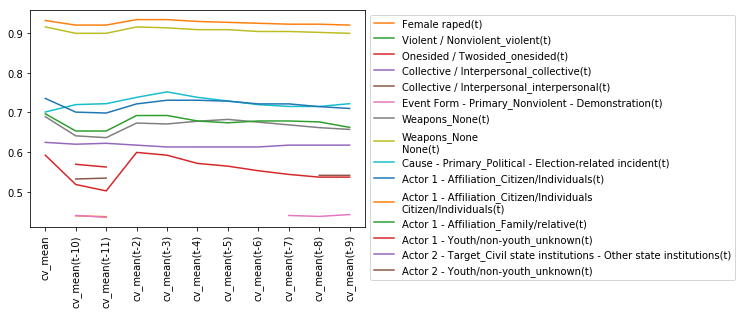

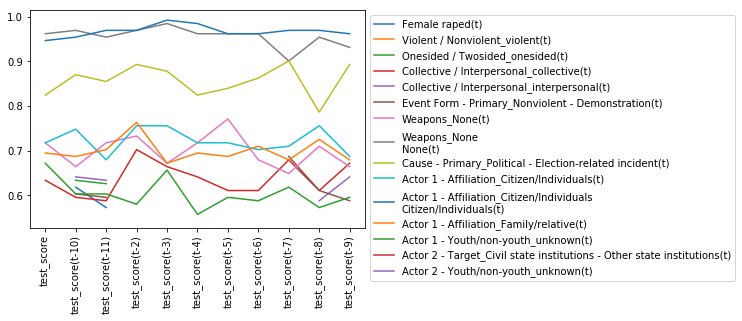

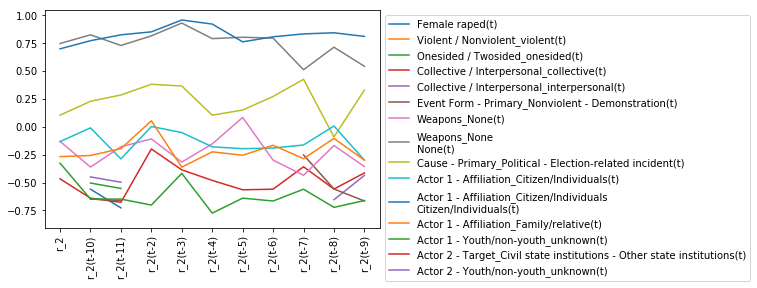

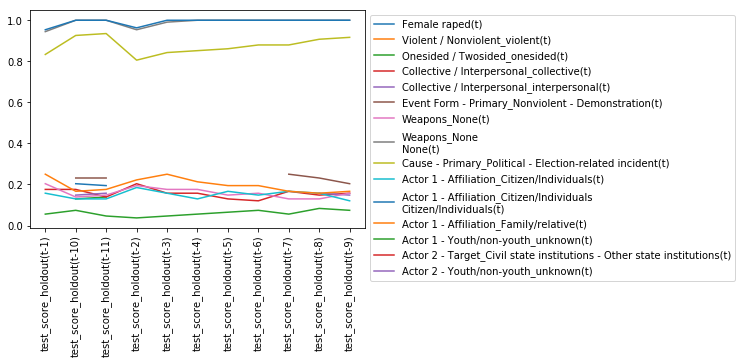

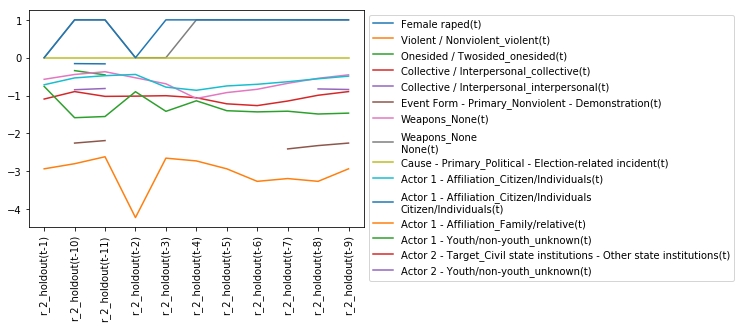

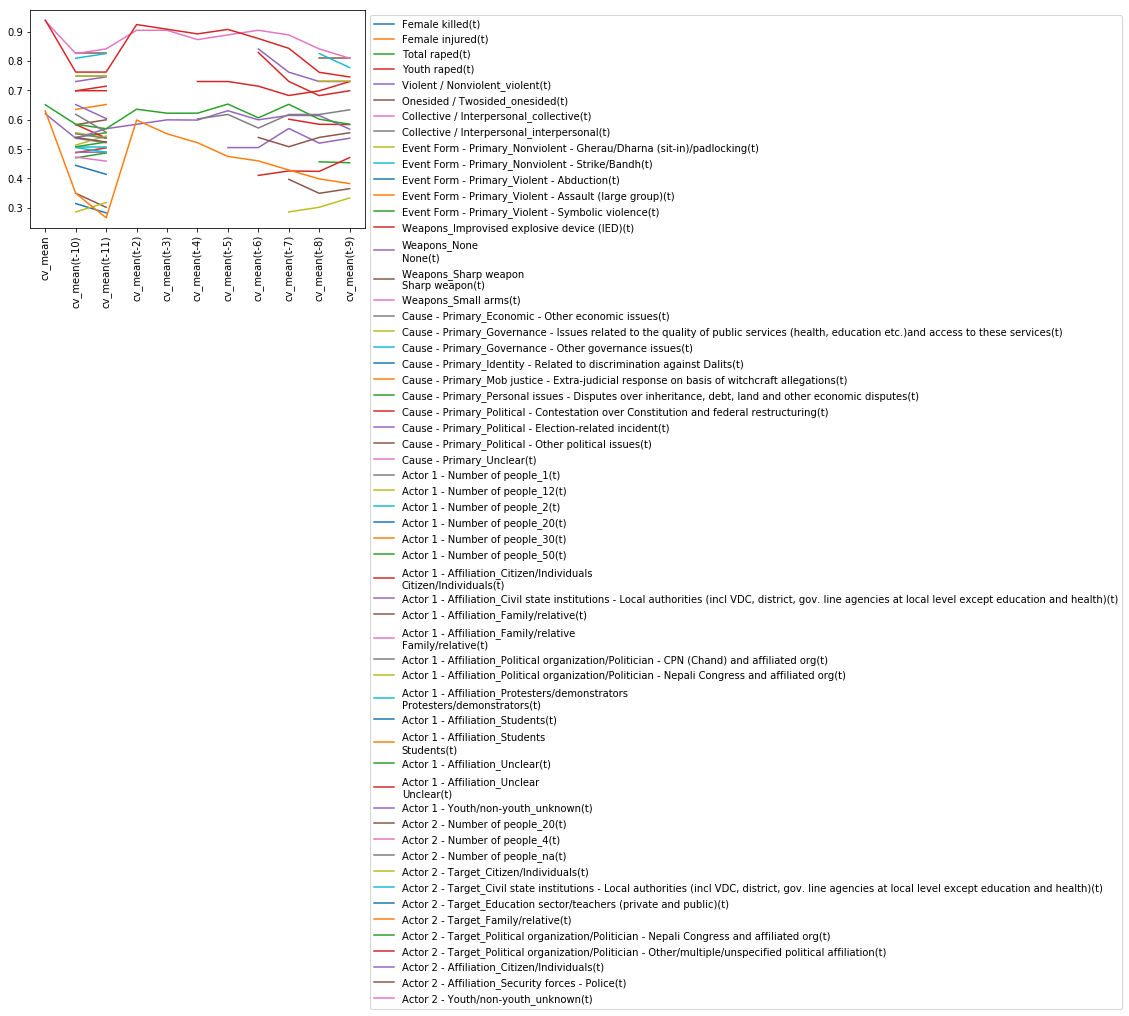

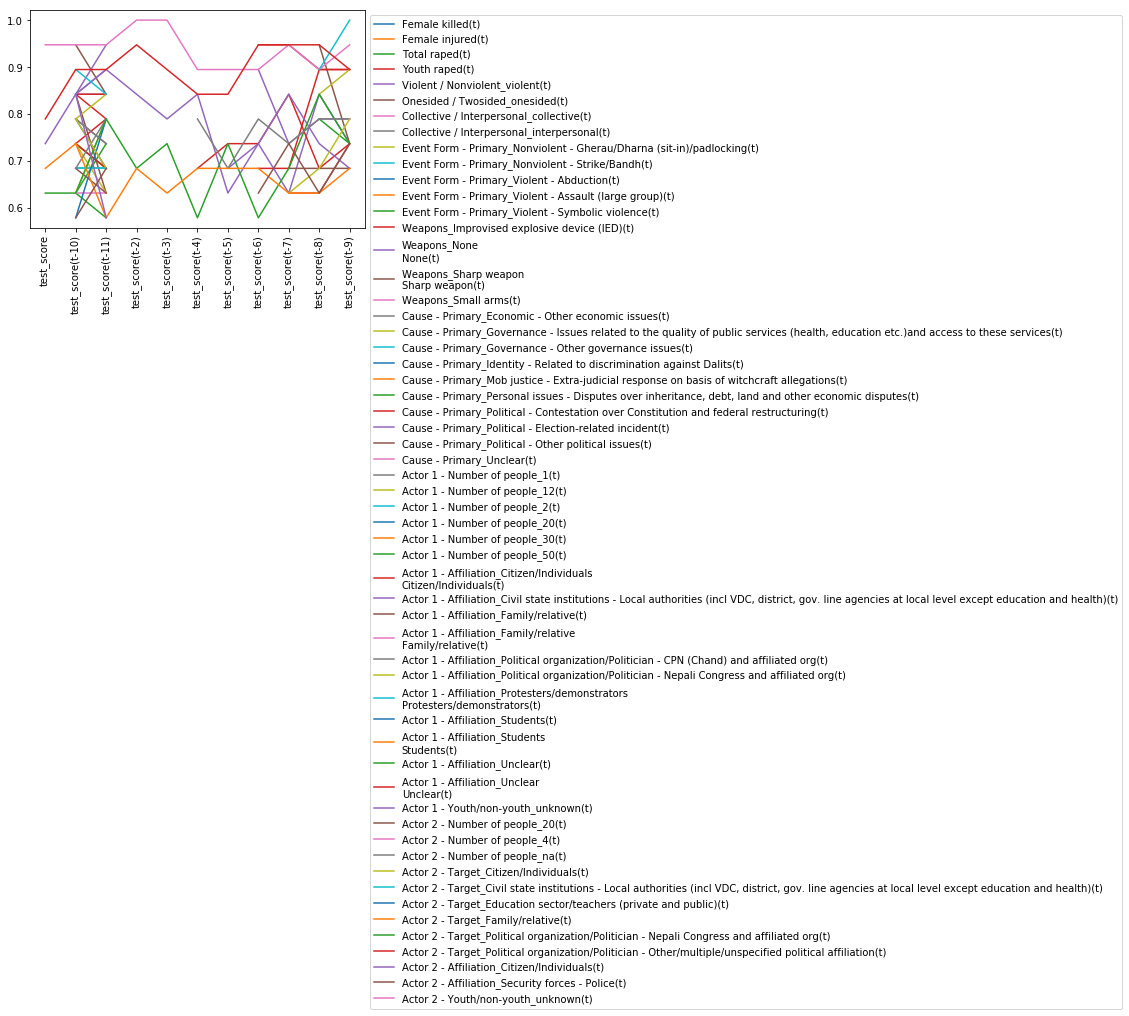

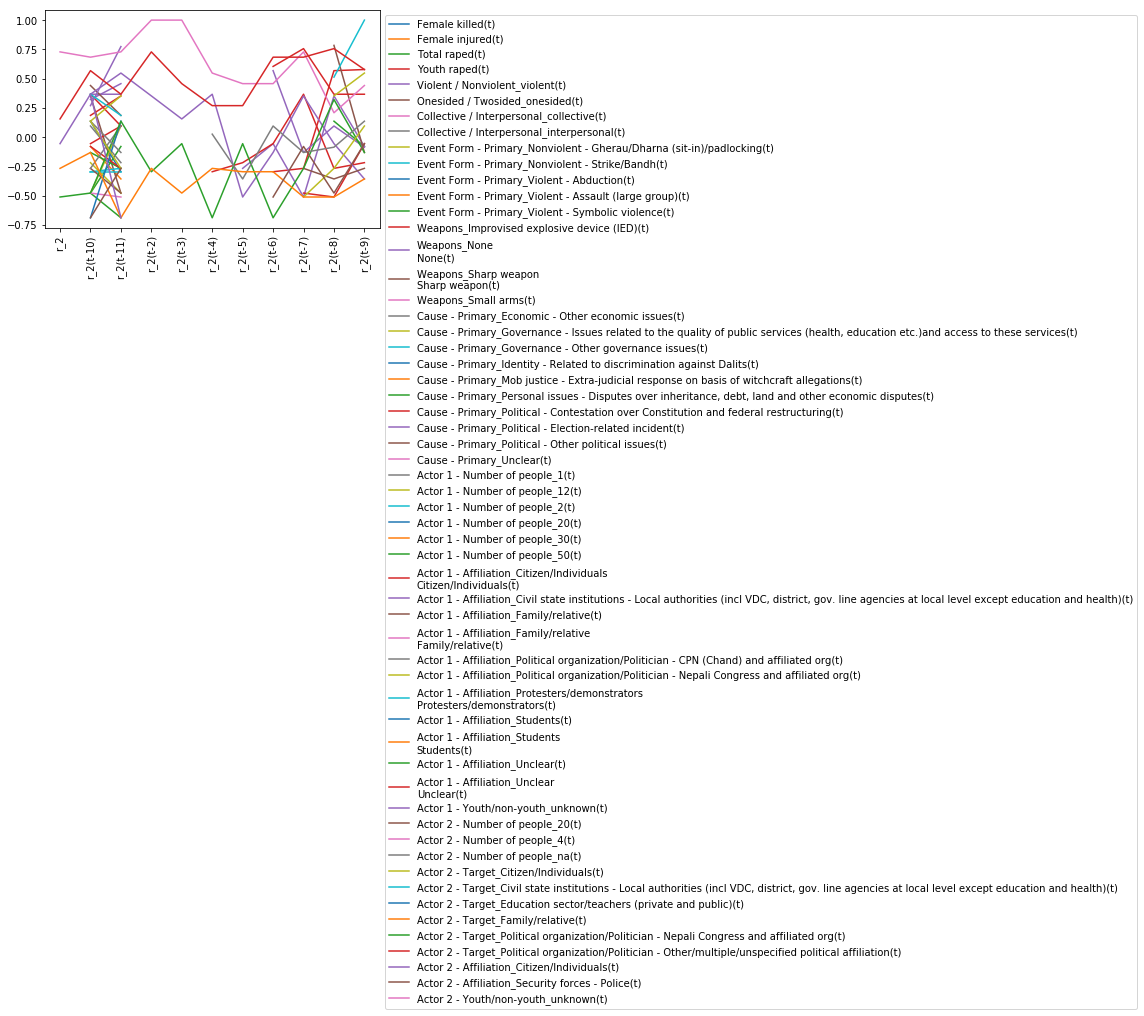

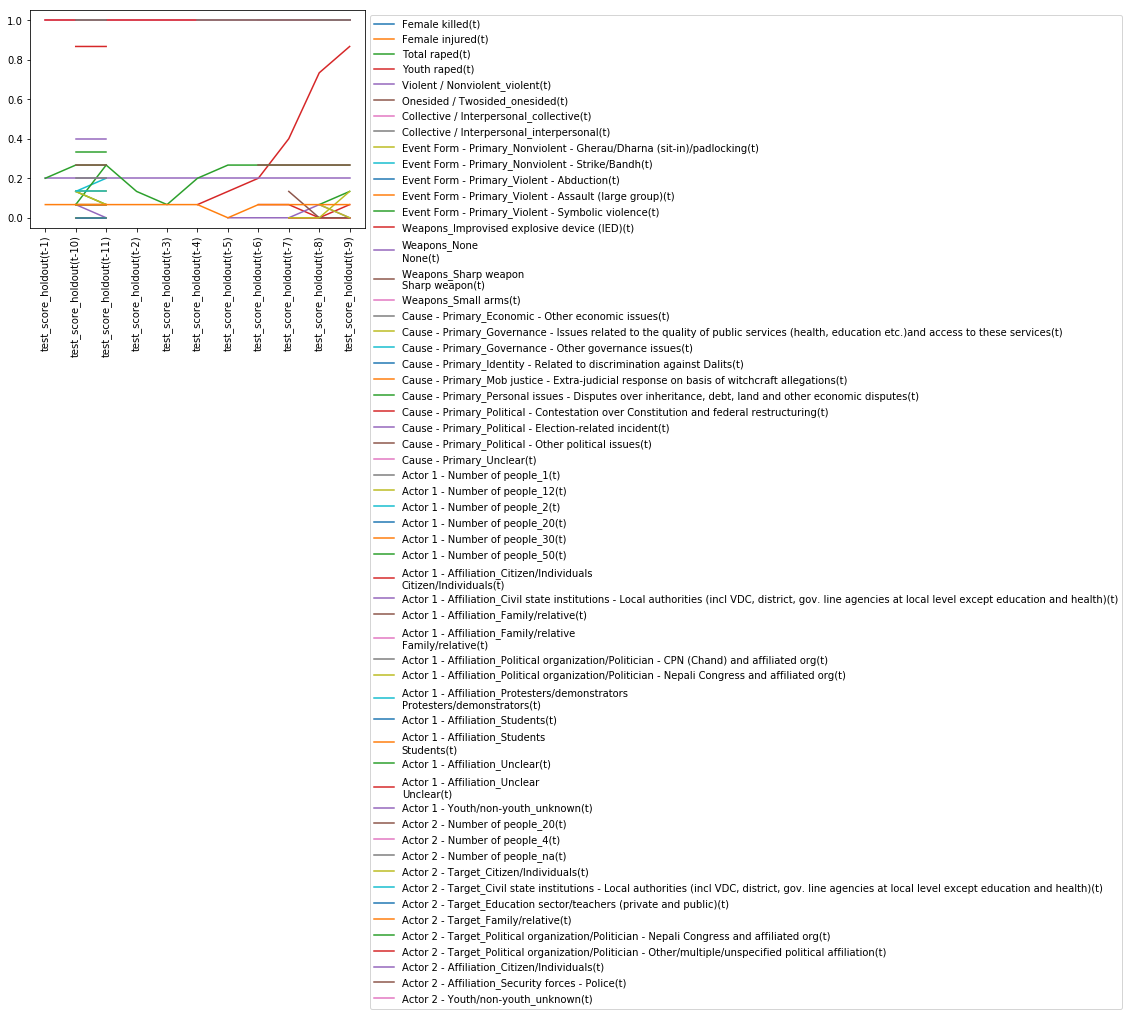

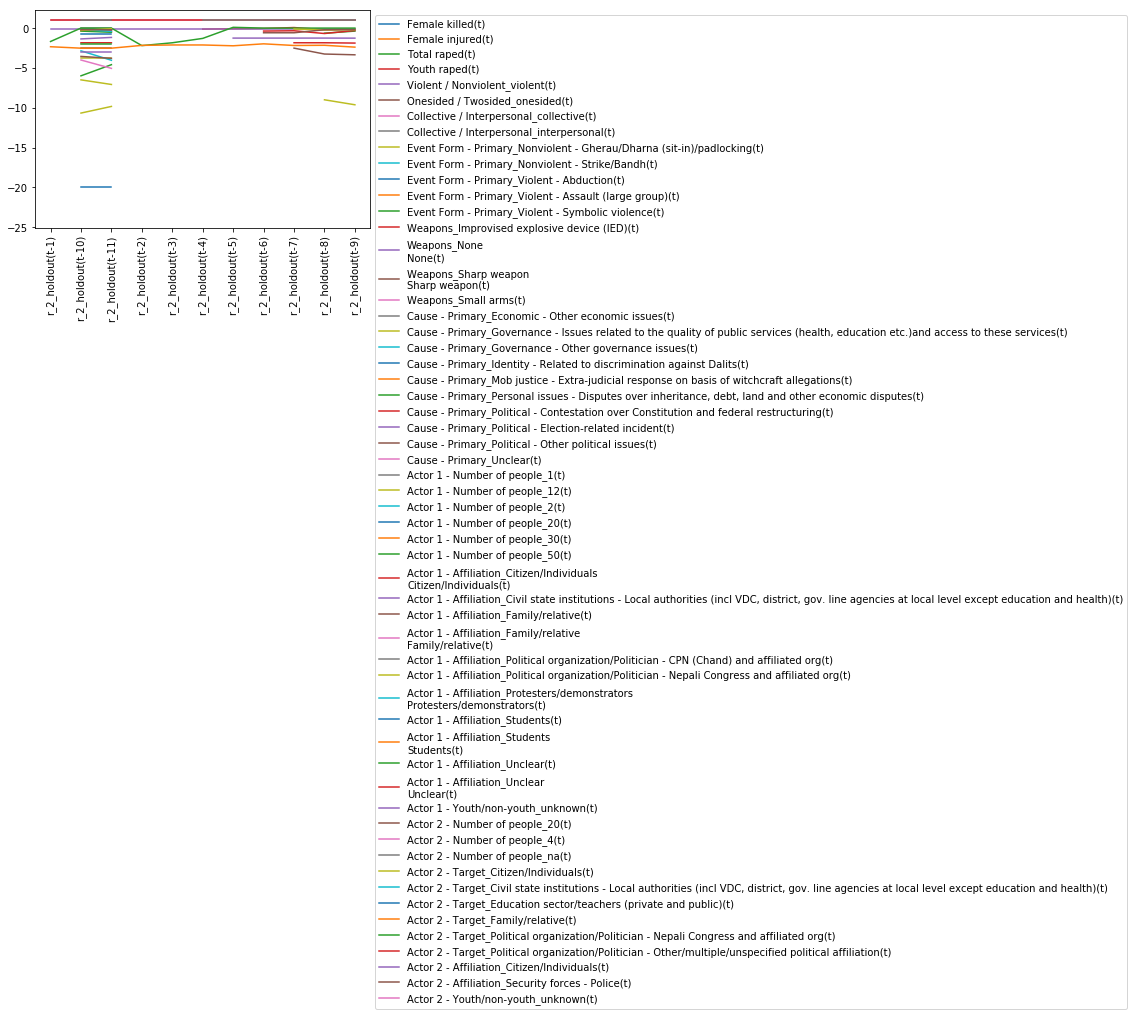

In [182]:
def plot_frame(df, step):
    plotvar = df.iloc[:,step::8]
    sortvar = plotvar.sort_index(axis=1, ascending=False)
    for label in sortvar.index:
        plt.plot(sortvar.loc[label,:], label=label)

    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    #print(plotvar)
    
for step in [0,1,3,5,7]:
    plot_frame(scoredf_day, step)

for step in [0,1,3,5,7]:
    plot_frame(scoredf_week, step)
    
#11 and 12 are out of order.. might be fixed with 2 digit indexing

In [73]:
#plt.plot(scorelist_day, label = 'by day')
#plt.plot(scorelist_week, label = 'by week')
#plt.title('Mean crossvalidation scores v. lookback times')
#plt.legend()
#plt.show()
#scoredf_day
#plt.plot()

#plt.show()
#scoredf_day.loc[:,::4]
plt.plot(scoredf_day.iloc[:,0::7].sort_values('cv_mean(t-3)')[:10], marker='.', linestyle='none')
plt.xticks(rotation=90)
plt.show()

KeyError: 'cv_mean(t-3)'

Note effectiveness of MultinomialNB() at predicting demonstrations and sit ins / collective violence based on indicators from the previous weeks. Indicators that ... and testing on the hold out set of this years data.

Perhaps proceed with dialing in collective violence. 

In [ ]:
#Dial in communal violence predictions


In [189]:
cv_scores_day = find_var(X_day, in_day, MultinomialNB(), n_true=20, verbose=False)
top10_day = cv_scores_day.sort_values('cv_mean', ascending=False)[:10]
top10_day

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . bing!


,cv_mean,test_score,confusion_matrix,pc_true
Actor 1 - Youth -25 years or below- involvement_Unknown,0.772313,0.890909,"[[84, 5], [7, 14]]",22.8022
Total Injured,5.43472e-322,0.718182,"[[66, 15], [16, 13]]",23.0769
Rape or Attempted Rape - Youth - 25 years or below,5.43472e-322,0.463636,"[[36, 52], [7, 15]]",23.9011
Actor 2 - Youth -25 years or below- involvement_No-youth,5.43472e-322,0.4,"[[30, 54], [12, 14]]",22.5275
Perpetrator 2 - if two-sided violence_ (),5.43472e-322,0.790909,"[[75, 10], [13, 12]]",23.0769
Target - if one-sided violence_Political organization/Politician - UML and affiliated org (0402),5.43472e-322,0.745455,"[[75, 11], [17, 7]]",23.6264
"Target - if one-sided violence_Civil state institutions - Local authorities (incl VDC, district, gov. line agencies at local level except education and health) (0204)",5.43472e-322,0.663636,"[[67, 22], [15, 6]]",20.3297
Actor 1 - Perpetrator Type_Unclear (9999),5.43472e-322,0.827273,"[[80, 9], [10, 11]]",20.6044
Actor 1 - Perpetrator Type_Security forces - Police (0101),5.43472e-322,0.709091,"[[76, 11], [21, 2]]",21.1538
Crosscutting issues_Elections,5.43472e-322,0.8,"[[77, 13], [9, 11]]",21.4286



 Actor 1 - Youth -25 years or below- involvement_Unknown

 Total Injured

 Rape or Attempted Rape - Youth - 25 years or below

 Actor 2 - Youth -25 years or below- involvement_No-youth

 Perpetrator 2 - if two-sided violence_ ()

 Target - if one-sided violence_Political organization/Politician - UML and affiliated org (0402)

 Target - if one-sided violence_Civil state institutions - Local authorities (incl VDC, district, gov. line agencies at local level except education and health) (0204)

 Actor 1 - Perpetrator Type_Unclear (9999)

 Actor 1 - Perpetrator Type_Security forces - Police (0101)

 Crosscutting issues_Elections
train score: 0.830708661417
test score: 0.736363636364
confusion matrix
   n,p
n [62  3] 
p [26 19]
crossvalidation mean: 0.758185431062 [ 0.77868852  0.7107438   0.78512397]


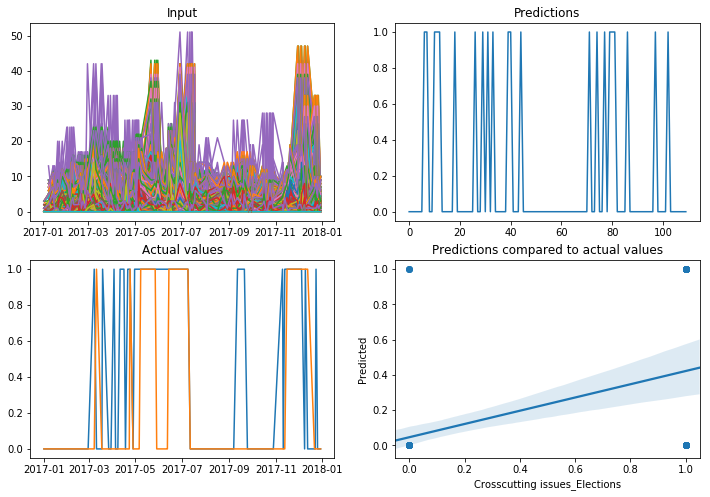

                                                                                                                       0         1
Event form - secondary_Non-violent - Arrest (politically significant) (28)(t-1)                                 0.103680  0.896320
Target - if one-sided violence_Political organization/Politician - RPP (0407)(t-7)                              0.106487  0.893513
Event form - secondary_Non-violent - Other forms of non-violent political protest (24)(t-2)                     0.115902  0.884098
Event form - primary_Violent - Symbolic violence (09)(t-2)                                                      0.127143  0.872857
Target - if one-sided violence_Political organization/Politician - CPN (Chand) and affiliated org (0404)(t-11)  0.127143  0.872857
                                                                                                            0         1
Actor 1 - Perpetrator Type_Health sector/health workers, doctors (2201)(t-11)                 

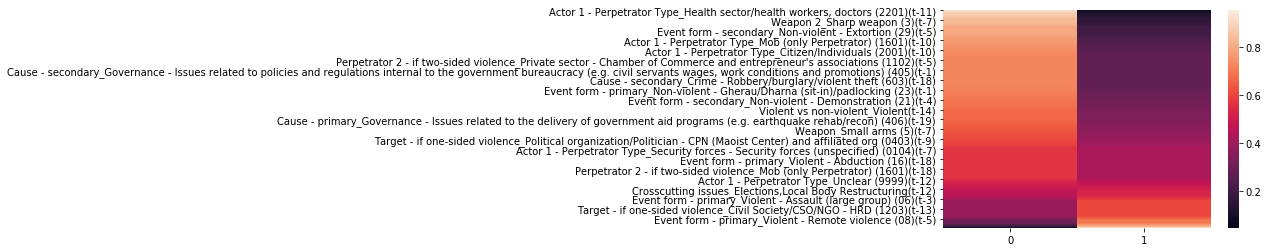

In [233]:
for cat in top10_day.index:
    print('\n',cat)
    y = in_day[cat] > 1
    cv_score, test_score, cm, log_proba = try_model(X_day, y, MultinomialNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X_day, y, MultinomialNB(), verbose = 2)
        interpet_prob(log_proba)

In [193]:
from sklearn.naive_bayes import BernoulliNB

BNB_scores = find_var(X, in_week, BernoulliNB(), n_true=20, verbose=False)
BNB_top10 = BNB_scores.sort_values('cv_mean', ascending=False)[:10]
BNB_top10

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . bing!


,cv_mean,test_score,confusion_matrix,pc_true
"Crosscutting issues_Constitutional Process,Local Body Restructuring",0.830065,0.875,"[[10, 1], [1, 4]]",22.6415
Target - if one-sided violence_Group of civilians (only Target) (1701),0.755991,0.9375,"[[14, 0], [1, 1]]",20.7547
Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404),0.755418,0.9375,"[[12, 1], [0, 3]]",24.5283
Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election,0.754902,0.875,"[[13, 0], [2, 1]]",22.6415
"Crosscutting issues_Elections,Constitutional Process",0.736383,0.9375,"[[12, 0], [1, 3]]",22.6415
Cause - secondary_ (),7.90505e-323,0.6875,"[[11, 0], [5, 0]]",24.5283
Actor 1 - Perpetrator Type_Criminal (1401),7.90505e-323,0.75,"[[12, 0], [4, 0]]",24.5283
Actor 1 - Perpetrator Type_Citizen/Individuals (2001),7.90505e-323,0.8125,"[[13, 0], [3, 0]]",20.7547
Crosscutting issues_GBV,7.90505e-323,0.875,"[[14, 0], [2, 0]]",20.7547
Crosscutting issues_Elections,7.90505e-323,0.8125,"[[13, 0], [3, 0]]",24.5283


In [228]:
for cat in BNB_top10.index[:5]:
    print('\n',cat)
    y = in_week[cat] > in_week[cat].quantile(.75)
    cv_score, test_score, cm, log_proba = try_model(X, y, BernoulliNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, BernoulliNB(), verbose = 2)
        interpet_prob(log_proba)


 Crosscutting issues_Constitutional Process,Local Body Restructuring

 Target - if one-sided violence_Group of civilians (only Target) (1701)

 Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404)

 Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election

 Crosscutting issues_Elections,Constitutional Process


In [230]:
for cat in BNB_top10.index[:5]:
    print('\n',cat)
    y = in_day[cat] > 1
    cv_score, test_score, cm, log_proba = try_model(X_day, y, BernoulliNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, BernoulliNB(), verbose = 2)
        interpet_prob(log_proba)


 Crosscutting issues_Constitutional Process,Local Body Restructuring

 Target - if one-sided violence_Group of civilians (only Target) (1701)

 Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404)

 Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election

 Crosscutting issues_Elections,Constitutional Process


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
rgs = RandomForestRegressor()
cls = RandomForestClassifier()
y = 
try_model(X, y, cls)

In [ ]:
top6 = cv_scores.sort_values('cv_mean', ascending=False)[:6]
top6

In [ ]:
s2 = pd.Series([6,8,3], index=list('abc'))
s4 = pd.Series([1,2,3], index=list('abc'))

s2 + s4